In [2]:
%matplotlib inline
import sys
import psycopg2
import psycopg2.extras
import numpy
import pandas
from matplotlib import pyplot

In [3]:
# Read scanscore into memory for further processing
with open("/global/homes/r/raknop/secrets/decatdb_decat_decat") as ifp:
    (user, passwd) = ifp.readline().strip().split()
db = psycopg2.connect(f"dbname='decat' user='{user}' password='{passwd}' host='decatdb.lbl.gov'",
                      cursor_factory=psycopg2.extras.RealDictCursor)
q = ( 'SELECT s.id,s.object_id,s.username,s.goodbad,o.rb '
      'FROM scanscore s '
      'INNER JOIN objects o ON s.object_id=o.id '
      'ORDER BY s.object_id' )
cursor = db.cursor()
cursor.execute(q)
scanscore = pandas.DataFrame( cursor.fetchall() )
cursor.close()
db.close()

In [4]:
# Show how many objects each user has vetted
print( scanscore.groupby(['username'])['object_id'].count().reset_index(name='count').sort_values(['count'], ascending=False) )

   username  count
5      ruby  16432
0    alexis  16110
4     rknop  12713
1    autumn  12263
2   caitlin   3495
3  penugent   2145
6  tkennedy    608


In [5]:
# Show stats on how many times a given object has been vetted
print( scanscore.groupby(['object_id'])['username'].count().reset_index(name='#vets')
       .groupby(['#vets'])['object_id'].count().reset_index(name="count") )

   #vets  count
0      1   7874
1      2  13474
2      3   7416
3      4   1499
4      5    134
5      6      5


In [6]:
# Show counts of num goods and num bads.  Not terribly meaningful by itself, we
#   really need to do cross counts
print( scanscore.groupby( ['object_id', 'goodbad'] )['object_id'].count().reset_index(name='num')
       .groupby( ['goodbad', 'num'] )['num'].count().reset_index(name='count') )

   goodbad  num  count
0      bad    1   9183
1      bad    2  11850
2      bad    3   5726
3      bad    4   1094
4      bad    5     86
5      bad    6      3
6     good    1   3854
7     good    2   1731
8     good    3    421
9     good    4     68
10    good    5      6


In [7]:
# Create a table where each row is one object, that has username and goodbad as lists
# GRR.  Even though I pass ndmin=1, I'm still getting 0-dimension arrays (really, just strings)
# This is annoying; it's why I have the numpy.array calls in the lambdas in the second two lines
objtable = scanscore.groupby( ['object_id', 'rb'] )["username", "goodbad"].agg(numpy.array, ndmin=1)
objtable["ngood"] = objtable["goodbad"].apply( lambda x: ( numpy.array( x, ndmin=1 ) == "good" ).sum() )
objtable["nbad"] = objtable["goodbad"].apply( lambda x: ( numpy.array( x, ndmin=1 ) == "bad" ).sum() )
objtable.reset_index(inplace=True)

In [8]:
print(objtable)

       object_id        rb         username      goodbad  ngood  nbad
0             63  0.000034             ruby          bad      0     1
1            162  0.000077           alexis          bad      0     1
2            258  0.007573   [ruby, alexis]   [bad, bad]      0     2
3            373  0.004164    [rknop, ruby]   [bad, bad]      0     2
4            419  0.000117    [rknop, ruby]   [bad, bad]      0     2
...          ...       ...              ...          ...    ...   ...
30397   10276932  0.448820   [ruby, autumn]  [bad, good]      1     1
30398   10276969  0.000649    [ruby, rknop]   [bad, bad]      0     2
30399   10277237  0.020764   [ruby, autumn]   [bad, bad]      0     2
30400   10278965  0.000452             ruby          bad      0     1
30401   10279112  0.038080  [rknop, autumn]   [bad, bad]      0     2

[30402 rows x 6 columns]


In [9]:
print( objtable.columns )

Index(['object_id', 'rb', 'username', 'goodbad', 'ngood', 'nbad'], dtype='object')


In [10]:
# Show consistency stats
maxgood = objtable['ngood'].max()
maxbad = objtable['nbad'].max()
print( f'{"nbad":>6s} |', end='' )
for j in range(maxbad+1):
    print( f' {j:5d} |', end='' )
print('\nngood  |', end='')
for j in range(maxbad+1):
    print( '       |', end='')
print('\n-------|', end='')
for j in range(maxbad+1):
    print( '-------|', end='')
print('')
for i in range(maxgood+1):
    print( f' {i:5d} |', end='' )
    for j in range(maxbad+1):
        n = ( ( objtable['ngood'] == i ) & ( objtable['nbad'] == j ) ).sum()
        print( f' {n:5} |', end='' )
    print('\n-------|', end='')
    for j in range(maxbad+1):
        print( '-------|', end='')
    print('')

  nbad |     0 |     1 |     2 |     3 |     4 |     5 |     6 |
ngood  |       |       |       |       |       |       |       |
-------|-------|-------|-------|-------|-------|-------|-------|
     0 |     0 |  6837 | 10771 |  5549 |  1076 |    86 |     3 |
-------|-------|-------|-------|-------|-------|-------|-------|
     1 |  1037 |  1676 |   954 |   170 |    17 |     0 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|
     2 |  1027 |   581 |   115 |     7 |     1 |     0 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|
     3 |   332 |    80 |     9 |     0 |     0 |     0 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|
     4 |    58 |     9 |     1 |     0 |     0 |     0 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|
     5 |     6 |     0 |     0 |     0 |     0 |     0 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|


In [11]:
# A function to add stats for a given user
def adduserstats( objtable, user ):
    if f"{user}_good" in objtable.columns:
        return
    sys.stderr.write( f"Adding isgood/isbad for {user}...\n" )
    def isgoodbad( row, user, goodbad ):
        dex = numpy.where(numpy.array( row["username"], ndmin=1 ) == user)[0]
        if dex.size == 0:
            return False
        else:
            return numpy.array( row["goodbad"], ndmin=1)[dex[0]] == goodbad
    objtable[f"{user}_good"] = objtable.apply( lambda row: isgoodbad(row, user, "good"), axis=1)
    objtable[f"{user}_bad"] = objtable.apply( lambda row: isgoodbad(row, user, "bad"), axis=1)
    sys.stderr.write( f"...done adding isgood/isbad for {user}.\n" )
    sys.stderr.flush()
    
# A function to print user stats
def userstats( objtable, user ):
    adduserstats( objtable, user )
    goodtable = objtable[ objtable[f"{user}_good"] ].groupby( [ f"ngood", f"nbad"] )["username"].count()
    print( f"Ratings for objects that {user} rated good:" )
    print( goodtable )
    badtable = objtable[ objtable[f"{user}_bad"] ].groupby( [f"ngood", f"nbad"] )["username"].count()
    print( f"Ratings for objects that {user} rated bad:" )
    print( badtable )
    
# A function to compare two users
def compareusers( objtable, user1, user2 ):
    adduserstats( objtable, user1 )
    adduserstats( objtable, user2 )
    goodgood = ( objtable[f"{user1}_good"] & objtable[f"{user2}_good"] ).sum()
    goodbad =  ( objtable[f"{user1}_good"] & objtable[f"{user2}_bad"] ).sum()
    badgood =  ( objtable[f"{user1}_bad"] & objtable[f"{user2}_good"] ).sum()
    badbad =   ( objtable[f"{user1}_bad"] & objtable[f"{user2}_bad"] ).sum()
    
    print( f'{user1:>8s} |   good   |    bad   |' )
    print( f'{user2:<8s} |          |          |' )
    print( f'---------------------------------' )
    print( f'good     |   {goodgood:4d}   |   {badgood:4d}   |' )
    print( f'---------------------------------' )
    print( f'bad      |   {goodbad:4d}   |   {badbad:4d}   |' )
    print( f'---------------------------------' )
              

In [12]:
userstats( objtable, "penugent" )

Adding isgood/isbad for penugent...
...done adding isgood/isbad for penugent.


Ratings for objects that penugent rated good:
ngood  nbad
1      0        2
       1       31
       2       27
       3       13
       4        3
2      0       32
       1       45
       2       15
       3        3
       4        1
3      0       32
       1       13
       2        2
4      0       13
       1        2
5      0        5
Name: username, dtype: int64
Ratings for objects that penugent rated bad:
ngood  nbad
0      1         8
       2       497
       3       758
       4       354
       5        46
       6         3
1      1        39
       2        81
       3        36
       4         6
2      1        31
       2        20
       3         3
3      1        18
       2         2
4      1         3
       2         1
Name: username, dtype: int64


In [13]:
compareusers( objtable, "rknop", "penugent" )

Adding isgood/isbad for rknop...
...done adding isgood/isbad for rknop.


   rknop |   good   |    bad   |
penugent |          |          |
---------------------------------
good     |     78   |     34   |
---------------------------------
bad      |    115   |    668   |
---------------------------------


In [14]:
# Make a histogram of rb scorer
def histrb( objtable, mode="unanimous", user=None, min=2 ):
    if mode == "user":
        if user is None:
            raise ValueError( "Must specify user for mode user" )
        adduserstats( objtable, user )
        bads = objtable[ objtable[f"{user}_bad"] ]
        goods = objtable[ objtable[f"{user}_good"] ]
        title = f"{user} rankings"
    elif mode == "unanimous":
        bads = objtable[ ( objtable["ngood"] == 0 ) & ( objtable["nbad"] >= min ) ]
        goods = objtable[ ( objtable["ngood"] >= min ) & ( objtable["nbad"] == 0 ) ]
        title = f"Unanimous vetting with at least {min} rankings"
    elif mode =="majority":
        bads = objtable[ ( objtable["ngood"] < objtable["nbad"] ) ]
        goods = objtable[ ( objtable["ngood"] > objtable["nbad"] ) ]
        title = "Majority vetting"
    else:
        raise ValueError( f"Unknown mode {mode}" )
    goodrb = goods["rb"].values
    badrb = bads["rb"].values
    # Have to do the range to 1.1 because numpy.hist doesn't count the right edge,
    #  and we definitely want to include rb=1.0
    bins = numpy.arange( 0., 1.2, 0.1 )
    goodhist, junk = numpy.histogram( goodrb, bins )
    badhist, junk = numpy.histogram( badrb, bins )
    fig = pyplot.figure( figsize=(10,6), tight_layout=True )
    ax = fig.add_subplot( 1, 1, 1 )
    ax.set_yscale("log")
    ax.set_title( title, fontsize=18 )
    ax.set_xlabel( 'rb', fontsize=18 )
    ax.set_ylabel( 'N', fontsize=18 )
    ax.tick_params( axis='both', labelsize=16 )
    ax.step( bins[:-1], goodhist, color='b', where="post" )
    ax.step( bins[:-1], badhist, color='r', where="post" )
    fig.show()
    return fig

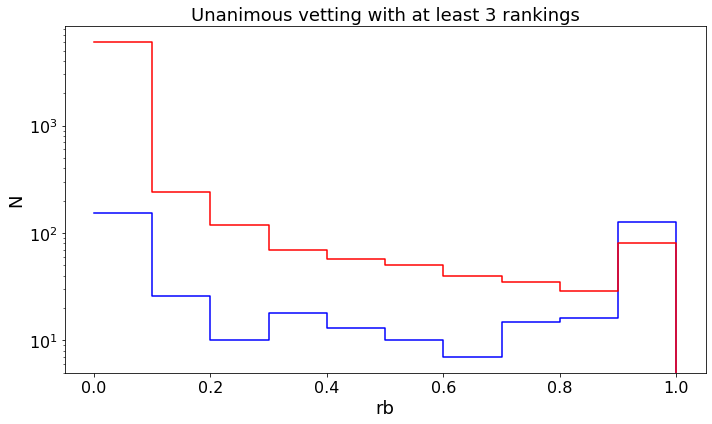

In [15]:
fig = histrb( objtable, mode="unanimous", min=3 )
fig.savefig( "vettingvsrb.svg" )